In [1]:
import pandas as pd
from partial_ranker import PartialRankerDFG
from partial_ranker import Graph

### The Class

In [2]:
%%writefile ../partial_ranker_dfg_r.py
# Partial Ranker
#
# Copyright (C) 2019-2024, Aravind Sankaran
# IRTG-2379: Modern Inverse Problems, RWTH Aachen University, Germany
# HPAC, Umeå University, Sweden
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# Contributors:
# - Aravind Sankaran

import pandas as pd
from .partial_ranker_dfg import PartialRankerDFG
from .graph import Graph

class PartialRankerDFGReduced:
    """DFG based partial ranking methodology (Methodology 2 in the paper). 
    First, the partial ranking is computed using Methodology 1. Then, the dependency graph from Methodology 1 is used to identify an alternative partial ranking with fewer ranks.
    The algorithm is implemented in the method ``compute_ranks()``.
    
    Input:
        comparer (partial_ranker.QuantileComparer):
            The ``QuantileComparer`` object that contains the results of pair-wise comparisons.
            i.e, ``comparer.compare()`` should have been called.
        
    **Attributes and Methods**:
    
    Attributes:
        objs (List[str]): List of object names.
        pr_dfg (partial_ranker.PartialRankerDFG): The partial ranking object which computes a parial ranking according to Methodology 1.
        graph_H (partial_ranker.Graph): The dependency graph that represents the rank relation among the objects according to Methodology 1.
    """

    def __init__(self,comparer):
        self.objs = comparer.objs
        self.comparer = comparer
        self.pr_dfg = PartialRankerDFG(comparer)
        self.graph_H = None
        
        self._obj_rank = {}
        self._rank_objs = {}
        
    def compute_ranks(self) -> None:
        """Computes the partial ranks of the objects according to Methodology 2.
        The internal variables that stores the rank of the objects are updated.
        """
        self._obj_rank = {}
        self._rank_objs = {}
        
        self.pr_dfg.compute_ranks()
        self.graph_H = Graph(self.pr_dfg.dependencies, self.pr_dfg.get_ranks())
        
        T = self.graph_H.get_separable_arrangement()
        R = [0]*len(T)
        self._update_rank_data(T[0],R[0])
        for i in range(1,len(T)):
            if self.comparer.C[T[i-1]][T[i]] == 0:
                R[i] = R[i-1] + 1
            else:
                R[i] = R[i-1]
            
            self._update_rank_data(T[i],R[i])  
            
            
    def _update_rank_data(self,obj,rank):
        self._obj_rank[obj] = rank
        self._rank_objs[rank] = self._rank_objs.get(rank,[]) + [obj] 
        
    def get_ranks(self) -> dict[int,list[str]]:
        """
        Returns:
            dict[int,List[str]]: A dictionary consisting of the list of objects at each rank.
            e.g.; ``{0: ['obj1'], 1: ['obj2', 'obj3'], ...}``.
        """
        return self._rank_objs
    
    def get_rank_obj(self,obj:str) -> int:
        """  
        Args:
            obj (str): Object name.
        
        Returns:
            int: The partial rank of a given object.
        """
        return self._obj_rank[obj]
    
    def get_dfg(self):
        """
        Returns:
            partial_ranker.Graph: A Graph object that represents the rank relation among the objects according to Methodology 2.
        """
        g = Graph(self.pr_dfg.dependencies, self.get_ranks()) 
        return g

Overwriting ../partial_ranker_dfg_r.py


### Requirements

In [4]:
import numpy as np
from partial_ranker.measurements_simulator import MeasurementsSimulator
from partial_ranker.measurements_visualizer import MeasurementsVisualizer
from partial_ranker import QuantileComparer

1) Prepare sample measurements

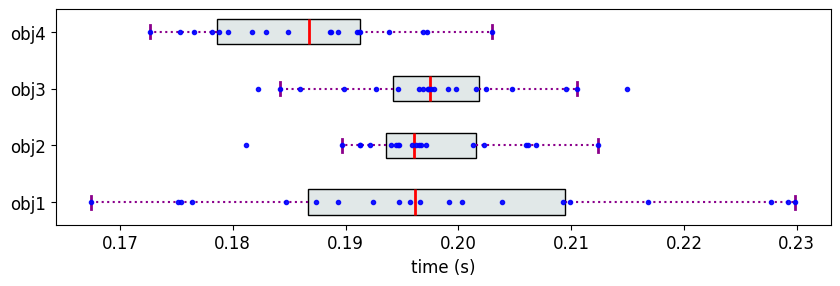

In [5]:
obj_params = {}
obj_params['obj1']  = [0.2,0.02] # [mean, std]
obj_params['obj2']  = [0.2,0.01]
obj_params['obj3']  = [0.2,0.01]
obj_params['obj4']  = [0.19,0.01]
ms = MeasurementsSimulator(obj_params,seed=129)
reps = 20
ms.measure(reps=reps)
measurements = ms.get_measurements()
h0 = list(obj_params.keys())
mv = MeasurementsVisualizer(measurements, h0)
fig = mv.show_measurements_boxplots(scale=0.7)

2) Compare

In [6]:
comparer = QuantileComparer(measurements)
comparer.compute_quantiles(q_max=75, q_min=25,outliers=False)
comparer.compare()
comparer.C

{'obj1': {'obj1': -1, 'obj2': 1, 'obj3': 1, 'obj4': 1},
 'obj2': {'obj1': 1, 'obj2': -1, 'obj3': 1, 'obj4': 2},
 'obj3': {'obj1': 1, 'obj2': 1, 'obj3': -1, 'obj4': 2},
 'obj4': {'obj1': 1, 'obj2': 0, 'obj3': 0, 'obj4': -1}}

### Usage

In [7]:
pr_dfg_r = PartialRankerDFGReduced(comparer)

In [8]:
pr_dfg_r.compute_ranks()

In [9]:
pr_dfg_r.get_ranks()

{0: ['obj4', 'obj1', 'obj2', 'obj3']}

In [10]:
pr_dfg_r._obj_rank

{'obj4': 0, 'obj1': 0, 'obj2': 0, 'obj3': 0}

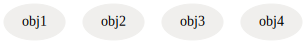

In [11]:
pr_dfg_r.get_dfg().visualize()

### Scaling experiment

In [12]:
def create_measurements(n_objs, n_reps, seed=129):
    obj_params = {}
    for i in range(n_objs):
        obj_params[f'obj{i}'] = [np.random.uniform(0,1), np.random.uniform(0,0.1)]
    ms = MeasurementsSimulator(obj_params,seed=seed)
    ms.measure(reps=n_reps)
    return ms.get_measurements()

In [13]:
measurements = create_measurements(20, 5)

In [15]:
#%%timeit -n 1 -r 3
cm = QuantileComparer(measurements)
cm.compute_quantiles(75, 25,False)
cm.compare()

In [16]:
pr_dfg_r = PartialRankerDFGReduced(cm)

In [17]:
#%%timeit -n 1 -r 3
pr_dfg_r.compute_ranks()

### Graph comparison (DFG reduced vs DFG)

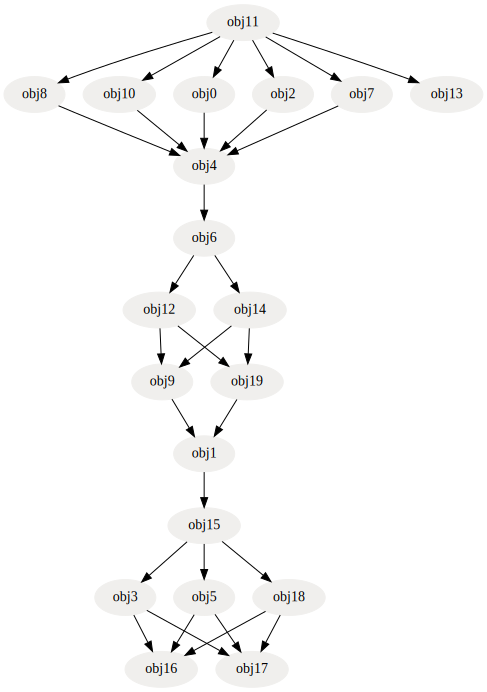

In [18]:
pr_dfg_r.get_dfg().visualize()

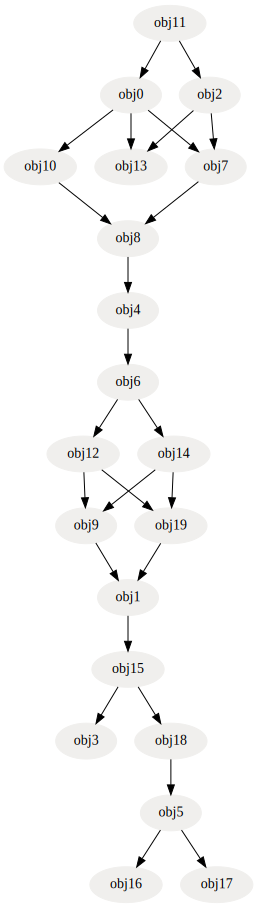

In [19]:
gr = Graph(pr_dfg_r.pr_dfg.dependencies, pr_dfg_r.pr_dfg.get_ranks())
gr.visualize()

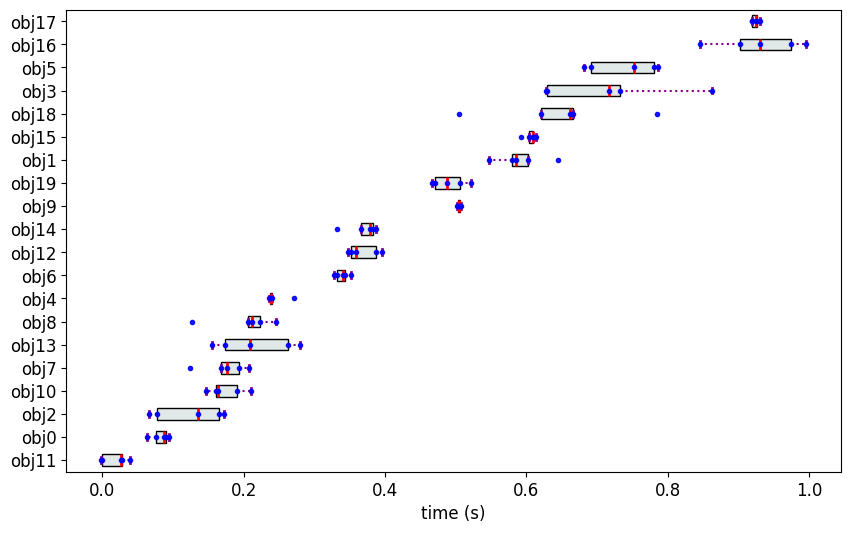

In [20]:
h0_ = gr.get_separable_arrangement()
mv = MeasurementsVisualizer(measurements, h0_)
fig = mv.show_measurements_boxplots(scale=0.3)